In [1]:
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

In [2]:
in_memory_store

In [4]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "chatbot with memory"

LANGCHAIN_API_KEY:  ········


In [5]:
import uuid

In [7]:
#namespace for the mmemory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a mmemory to namespace as key and value
key = str(uuid.uuid4())

#value needs to be a dictionary
value = {"movie_preference": "I like comedy"}

# Save the mmemory
in_memory_store.put(namespace_for_memory, key=key, value=value)

In [8]:
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [9]:
# Metadata
memories[0].dict()

{'value': {'movie_preference': 'I like comedy'},
 'key': '16ffba5a-6d57-4a1c-930a-3217d9851103',
 'namespace': ['1', 'memories'],
 'created_at': '2024-12-28T09:56:42.884032+00:00',
 'updated_at': '2024-12-28T09:56:42.884032+00:00',
 'score': None}

In [10]:
# The key, value
print(memories[0].key, memories[0].value)

16ffba5a-6d57-4a1c-930a-3217d9851103 {'movie_preference': 'I like comedy'}


In [12]:
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'value': {'movie_preference': 'I like comedy'},
 'key': '16ffba5a-6d57-4a1c-930a-3217d9851103',
 'namespace': ['1', 'memories'],
 'created_at': '2024-12-28T09:56:42.884032+00:00',
 'updated_at': '2024-12-28T09:56:42.884032+00:00'}

CHATBOT WITH LONG-TERM MEMORY:

for short-term i'll use a CHECKPOINTER and for long-term i'll use LANGGRAPH STORE

In [13]:
_set_env("HUGGINGFACEHUB_API_KEY")

HUGGINGFACEHUB_API_KEY:  ········


In [14]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

llm = HuggingFaceEndpoint(
    repo_id="HuggingFaceH4/zephyr-7b-beta",
    task="text-generation",
    max_new_tokens=300,
    do_sample=False,
    repetition_penalty=1.03,
)

model = ChatHuggingFace(llm=llm)

In [15]:
model

ChatHuggingFace(llm=HuggingFaceEndpoint(repo_id='HuggingFaceH4/zephyr-7b-beta', max_new_tokens=300, repetition_penalty=1.03, stop_sequences=[], server_kwargs={}, model_kwargs={}, model='HuggingFaceH4/zephyr-7b-beta', client=<InferenceClient(model='HuggingFaceH4/zephyr-7b-beta', timeout=120)>, async_client=<InferenceClient(model='HuggingFaceH4/zephyr-7b-beta', timeout=120)>, task='text-generation'), tokenizer=LlamaTokenizerFast(name_or_path='HuggingFaceH4/zephyr-7b-beta', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='left', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>', 'additional_special_tokens': ['<unk>', '<s>', '</s>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalize

In [18]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

In [19]:
# Chatbot instruction 
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

In [21]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace=namespace, key=key)

    # Extract the actual memory if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key 
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found"

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)

    # Respond using memory as well as the chat history 
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])
    
    return {"messages": response}

In [22]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing memory in the store 
    key = "user_memory"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.content})

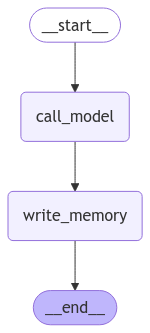

In [23]:
# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [24]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Kings")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Kings
================================== Ai Message ==================================

Hello, Kings. Based on our past interactions, I know that you are interested in learning more about technology trends and business strategies. I can provide you with articles, reports, and insights related to these topics. Is there anything else you'd like me to remember about you? Let me know, and I'll update my records accordingly.


In [25]:
# User input 
input_messages = [HumanMessage(content="I'd like to know how i can apply my knowledge in AI to earn a living")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I'd like to know how i can apply my knowledge in AI to earn a living
================================== Ai Message ==================================

There are several career paths you can consider in the field of AI to earn a living, depending on your skills and experience. Here are some options:

1. Data Scientist: As a data scientist, you will work on developing AI models, analyzing data, and interpreting insights for businesses and organizations. This role requires a strong background in statistics, mathematics, and computer science, along with experience in machine learning and deep learning algorithms.

2. Machine Learning Engineer


Here MemorySaver checkpointer is being used as it saves the chat history within thread. 

I'll have a look at it below

In [26]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Kings
================================== Ai Message ==================================

Hello, Kings. Based on our past interactions, I know that you are interested in learning more about technology trends and business strategies. I can provide you with articles, reports, and insights related to these topics. Is there anything else you'd like me to remember about you? Let me know, and I'll update my records accordingly.
================================ Human Message =================================

I'd like to know how i can apply my knowledge in AI to earn a living
================================== Ai Message ==================================

There are several career paths you can consider in the field of AI to earn a living, depending on your skills and experience. Here are some options:

1. Data Scientist: As a data scientist, you will work on developing AI models, analyzing data, a

Below i'll confirm if the the memory was saved to store "across_thread_memory" compiled with InMemoryStore function.

In [27]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'value': {'memory': "Based on your recent question, I want to make sure your user information is up-to-date. Here's how I'll update it:\n\nUSER INFORMATION:\n- Name: Kings\n- Interests: technology trends, business strategies, AI and data science\n- Goals: applying AI knowledge to earn a living\n\nThe above goal you stated aligns with your interest in AI. As we discuss your options in applying your AI knowledge to earn a living,"},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2024-12-28T10:16:51.285023+00:00',
 'updated_at': '2024-12-28T10:16:51.285023+00:00'}

I want to see if the chatbot will remember my profile and use it to personalize my response if i start a new thread with same ID

In [29]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend that kickstart my job searching journey in AI?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that kickstart my job searching journey in AI?
================================== Ai Message ==================================

As you've expressed interest in applying AI knowledge to earn a living, and considering your goal, I'd suggest you start by exploring AI job opportunities in the following areas:

1. Machine Learning Engineering: This role requires a solid background in mathematical concepts, statistics, programming languages such as Python, and expertise in machine learning algorithms.

2. Data Scientist: As a data scientist, you'll analyze complex data sets, extract valuable insights, and work in collaboration with developers


In [31]:
# User input 
input_messages = [HumanMessage(content="Great, can i know the median salaries for the jobs? i would like to know which one is more lucrative ")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Great, can i know the median salaries for the jobs? i would like to know which one is more lucrative 
================================== Ai Message ==================================

According to recent reports, median salaries for machine learning engineers and data scientists in the United States are as follows:

- Machine Learning Engineer: $142,000 - $153,00
- Data Scientist: $126,000 - $152,00

These ranges may vary depending on the company size, location, and level of experience.

In terms of salary, both machine learning engineers
